# VAR Model

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('Data/PCEPersonalSpending.csv', index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [3]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [5]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [7]:
df = df.join(sp)

In [8]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [9]:
df.shape

(252, 2)

In [11]:
df = df.dropna()

In [12]:
df.shape

(252, 2)

<AxesSubplot:xlabel='Date'>

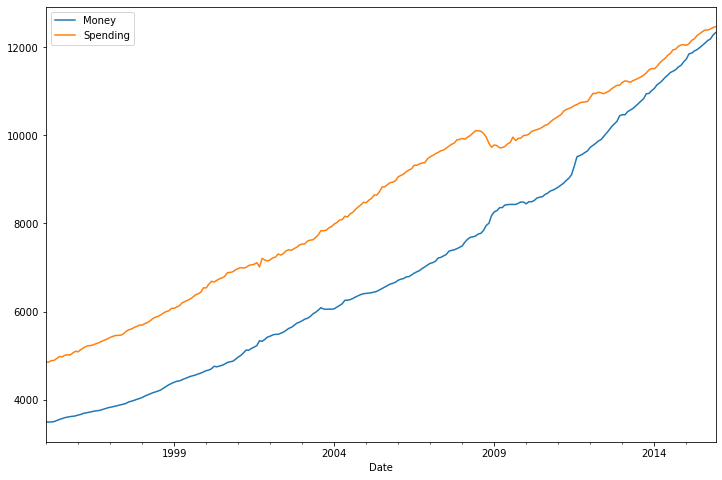

In [14]:
df.plot(figsize=(12,8))

## Differencing

In [16]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag = 'AIC')
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# obervations']
    out = pd.Series(result[0:4], index = labels)
    
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis')
        print('Reject the null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non-stationary')

In [18]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# obervations           247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [19]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# obervations           248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [21]:
df_transformed = df.diff()

In [22]:
print(adf_test(df_transformed['Money']))
print(adf_test(df_transformed['Spending']))

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# obervations           235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None
Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# obervations           2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None


In [24]:
df_transformed = df_transformed.diff().dropna()

In [25]:
df_transformed

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7
...,...,...
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5


In [26]:
print(adf_test(df_transformed['Money']))
print(adf_test(df_transformed['Spending']))

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# obervations           2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None
Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# obervations           2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None


## Train and Test Split

In [28]:
# Number of Obervations
nobs = 12

In [29]:
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

In [35]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


## GRIDSEARCH FOR ORDER p AR of VAR model

In [40]:
model = VAR(train)

for p in [1,2,3,4,5,6,7]:
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 14.178610495220896


ORDER 2
AIC: 13.955189367163703


ORDER 3
AIC: 13.849518291541038


ORDER 4
AIC: 13.827950574458283


ORDER 5
AIC: 13.78730034460964


ORDER 6
AIC: 13.799076756885809


ORDER 7
AIC: 13.797638727913972




In [41]:
results = model.fit(5)

In [42]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 16, Oct, 2020
Time:                     12:55:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [43]:
# Grab 5 Lagged values, right before the test starts!
# Numpy array

In [48]:
lagged_values = train.values[-5:]

In [50]:
z = results.forecast(y=lagged_values, steps = 12)

In [51]:
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [52]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [53]:
idx = pd.date_range('2015-01-01', periods=12, freq = 'MS')

In [54]:
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [55]:
df_forecast = pd.DataFrame(data=z, index=idx, columns=['Money_2d', 'Spending_2d'])

In [56]:
df_forecast

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


## Invert the Transformation

In [57]:
df_forecast['Money_1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money_1d'].cumsum()

In [58]:
df_forecast['Spending_1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending_1d'].cumsum()

In [65]:
test_range = df[-nobs:]

<AxesSubplot:>

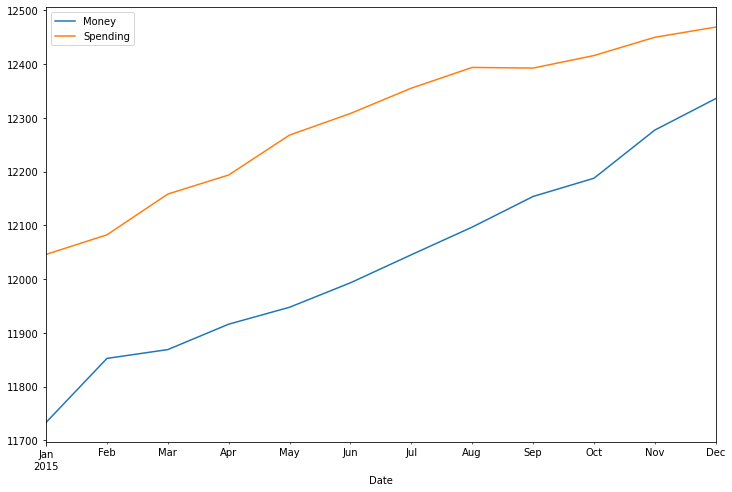

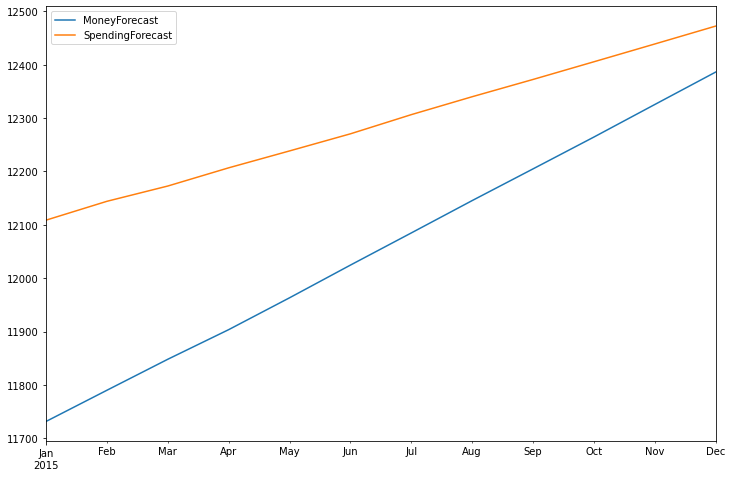

In [70]:
test_range.plot(figsize = (12,8))
df_forecast[['MoneyForecast','SpendingForecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

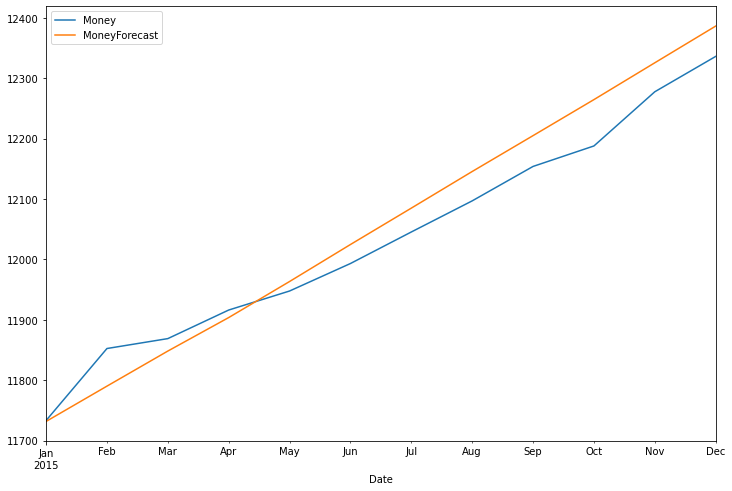

In [74]:
test_range['Money'].plot(legend=True, figsize=(12,8))
df_forecast['MoneyForecast'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

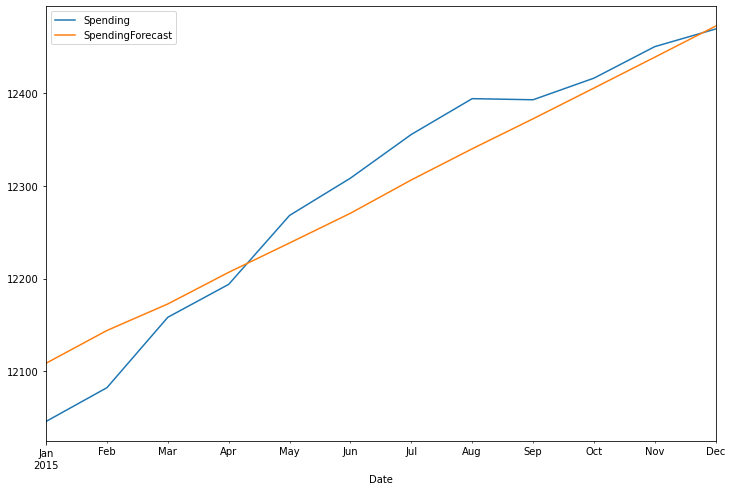

In [75]:
test_range['Spending'].plot(legend=True, figsize=(12,8))
df_forecast['SpendingForecast'].plot(legend=True)

In [76]:
rmse(test_range['Money'], df_forecast['MoneyForecast'])

43.71049653558893

In [77]:
test_range['Money'].mean()

12034.008333333333

In [78]:
rmse(test_range['Spending'], df_forecast['SpendingForecast'])

37.001175169408036

In [79]:
test_range['Spending'].mean()

12294.533333333335

# VARMA Model

In [80]:
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('Data/PCEPersonalSpending.csv', index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [84]:
df = df.join(sp)

In [85]:
df

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


In [87]:
auto_arima(df['Money'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, with_intercept=False)

In [88]:
auto_arima(df['Spending'], maxiter = 1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={})

In [89]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [90]:
len(df_transformed)

250

## Train / Test Split

In [91]:
nobs = 12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [92]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


## Fit the VARMA(1,2) Model

In [94]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter = 1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2285.860
,+ intercept,AIC,4605.720
Date:,"Fri, 16 Oct 2020",BIC,4664.749
Time:,13:32:48,HQIC,4629.510
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"67.60, 28.85",Jarque-Bera (JB):,"552.05, 127.75"
Prob(Q):,"0.00, 0.90",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.55, 2.87",Skew:,"1.34, -0.32"


## Predict the next 12 values

In [95]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.050219,37.367991
2015-02-01,-11.097937,-4.699904
2015-03-01,1.242635,-0.144623
2015-04-01,-1.663244,-0.442775
2015-05-01,0.991430,0.254518
2015-06-01,-0.352719,-0.038456
2015-07-01,0.480741,0.158538
2015-08-01,0.002947,0.048803
2015-09-01,0.284976,0.114297
2015-10-01,0.120333,0.076220


## Invert the Transformation

In [98]:
df_forecast['Money_1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money_1d'].cumsum()

In [99]:
df_forecast['Spending_1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending_1d'].cumsum()

In [100]:
df_forecast

,Money,Spending,Money_1d,MoneyForecast,Spending_1d,SpendingForecast
2015-01-01,-11.050219,37.367991,67.549781,11737.649781,47.967991,12109.967991
2015-02-01,-11.097937,-4.699904,56.451845,11794.101626,43.268087,12153.236078
2015-03-01,1.242635,-0.144623,57.694479,11851.796105,43.123464,12196.359542
2015-04-01,-1.663244,-0.442775,56.031235,11907.827340,42.680689,12239.040232
2015-05-01,0.991430,0.254518,57.022665,11964.850005,42.935207,12281.975439
2015-06-01,-0.352719,-0.038456,56.669946,12021.519951,42.896751,12324.872190
2015-07-01,0.480741,0.158538,57.150687,12078.670637,43.055290,12367.927480
2015-08-01,0.002947,0.048803,57.153633,12135.824271,43.104092,12411.031572
2015-09-01,0.284976,0.114297,57.438610,12193.262881,43.218389,12454.249961
2015-10-01,0.120333,0.076220,57.558942,12250.821823,43.294609,12497.544570


In [101]:
pd.concat([df.iloc[-12:], df_forecast[['MoneyForecast','SpendingForecast']]], axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11737.649781,12109.967991
2015-02-01,11852.4,12082.4,11794.101626,12153.236078
2015-03-01,11868.8,12158.3,11851.796105,12196.359542
2015-04-01,11916.1,12193.8,11907.827340,12239.040232
2015-05-01,11947.6,12268.1,11964.850005,12281.975439
2015-06-01,11993.1,12308.3,12021.519951,12324.872190
2015-07-01,12045.3,12355.4,12078.670637,12367.927480
2015-08-01,12096.8,12394.0,12135.824271,12411.031572
2015-09-01,12153.8,12392.8,12193.262881,12454.249961


## Plots

<AxesSubplot:xlabel='Date'>

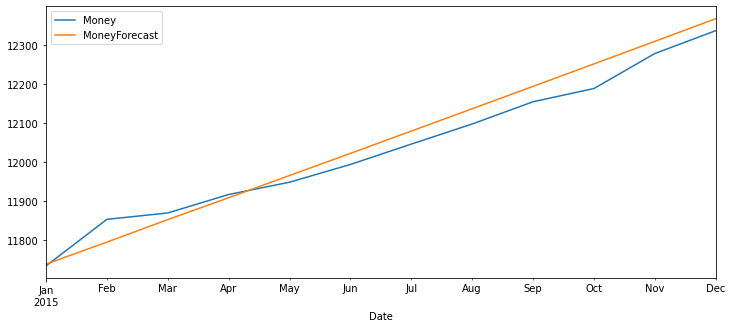

In [102]:
df['Money'][-nobs:].plot(figsize=(12,5), legend=True).autoscale(axis='x', tight=True)
df_forecast['MoneyForecast'].plot(legend=True)